In [2]:
import numpy as np
import numpy.testing as npt
import matplotlib.pyplot as plt
import mnist
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.interpolate import RegularGridInterpolator

### Help functions

In [2]:
def gaussian(n: np.ndarray, mu: np.ndarray, sigma: float, use_log: bool):
    N = n.shape[1]

    scale = ((N - 1.) / 2.) / np.log((N + 1) / 2.) if use_log else 1.

    def log(x):
        return np.log(x) if use_log else x - 1

    result = np.zeros((N, N))
    for l1 in [-N, 0, N]:
        for l2 in [-N, 0, N]:
            norm = np.linalg.norm(n + np.array([l1, l2]).reshape(-1, 1, 1), axis=0)
            result += np.exp(
                -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)
                / sigma)
    return result

In [3]:
def expand_mnist(img):
    npt.assert_array_equal(img.shape, (28, 28))
    expanded_matrix = np.zeros((101, 101))
    expanded_matrix[36:64, 36:64] = img
    return expanded_matrix

In [4]:
def regrid(data, out_x, out_y):
    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, out_y), np.linspace(0, 1.0/m, out_x))

    return interpolating_function((xv, yv))

In [5]:
def standardize_matrix(matrix):
    scaler = MinMaxScaler()
    X_one_column = matrix.reshape([-1,1])
    result_one_column = scaler.fit_transform(X_one_column)
    return result_one_column.reshape(matrix.shape)

In [6]:
def normalized_dot(a, b):
    return np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(b)))

In [7]:
def normalized_dot_2(a, b):
    return np.sum(a * b)/(np.sqrt(np.sum(np.square(a))) * np.sqrt(np.sum(np.square(b))))

In [103]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(a, b):
    v1_u = unit_vector(a)
    v2_u = unit_vector(b)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [179]:
def angle_between_2(a, b):
    norms = np.linalg.norm(a) * np.linalg.norm(b)
    inner_prod = np.dot(a.flatten(), b.flatten())
    return np.arccos(inner_prod/norms)
    

## T-sne on regular mnist, limit to 10 000

In [3]:
imgs = mnist.train_images()/255.0
labels = mnist.train_labels()
subset = imgs[0:10000]
labels = labels[0:10000]
subset_flattened = subset.reshape(10000, 784)
subset_flattened.shape

AttributeError: module 'mnist' has no attribute 'train_images'

In [9]:
standardized_data = StandardScaler().fit_transform(subset_flattened)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(standardized_data)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [9]:
def make_t_sne(tsne, y, title):
    plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=y, cmap='Spectral')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title(title, fontsize=12)

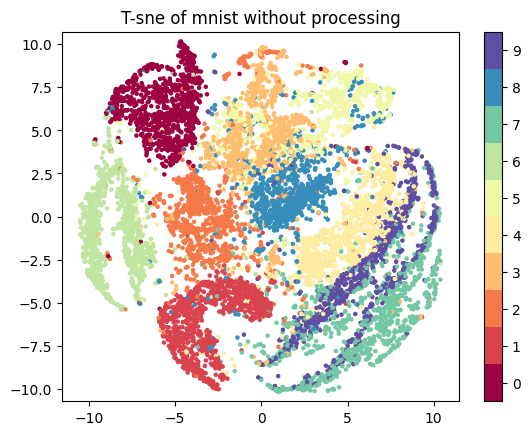

In [8]:
make_t_sne(tsne=tsne, y=labels, title='T-sne of mnist without processing')

### Making filter bank

Filter size = 101x101

Sigma = 100

r = [ 6, 12, 18, 24, 30, 36, 42]

angles = 0 to pi, subdivided into 12

Gives 7 * 12 filters

In [97]:
filterbank = []
abs_filterbank = []

/var/folders/rm/3d0_pm1j4d7dxnhy7q6160tr0000gn/T/ipykernel_38582/3487998290.py:14: RuntimeWarning: invalid value encountered in divide
  -np.square(scale * np.where(norm > 0, (n + np.array([l1, l2]).reshape(-1, 1, 1)) / norm * log(norm + 1), 0.) - mu.reshape(-1, 1, 1)).sum(axis=0)


<Figure size 3000x1725 with 0 Axes>

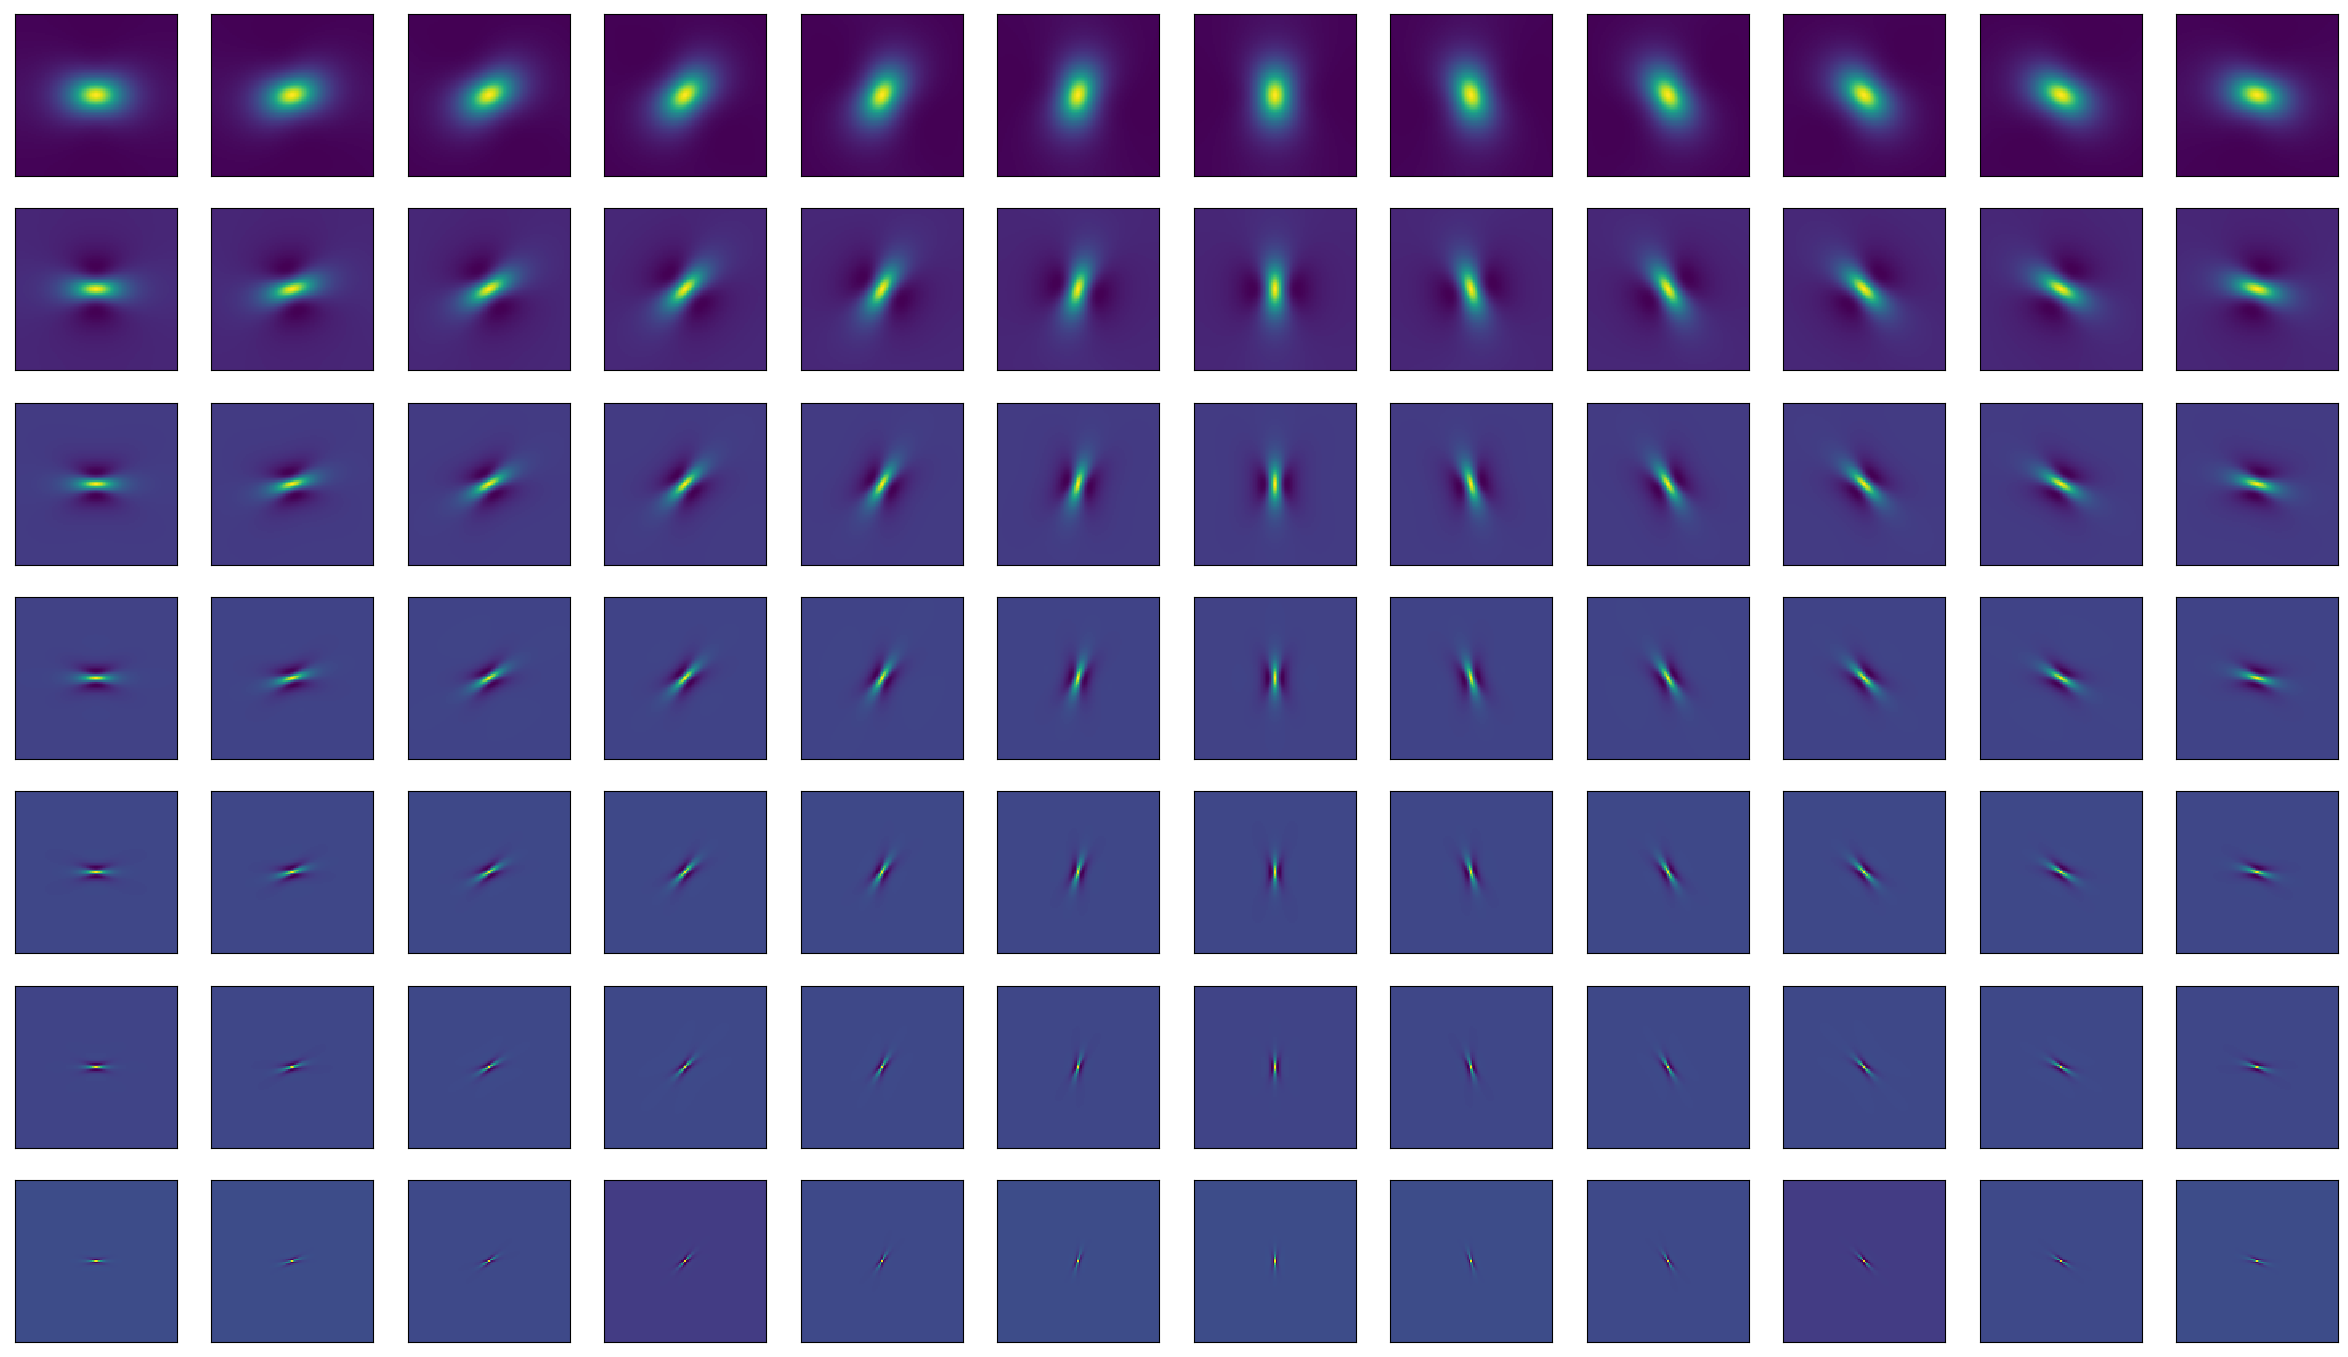

In [98]:
N = 101
n1 = np.arange(N).reshape((-1, 1)).repeat(N, axis=1) - (N - 1) / 2
n2 = n1.T
n = np.array([n1, n2])

plt.rcParams.update({
    "figure.figsize": np.array([120, 69]) * 0.25,
})

mu = np.array([20., 20.])
sigma = 100.
plt.tight_layout(pad=0.0)
#plt.figure(figsize=(60, 17.25))
dr = 6.
dtheta = np.pi / 12.
fig, axes = plt.subplots(7, 12)
i, j = (0, 0)

for theta in np.arange(0., np.pi, dtheta):
    for r in np.arange(dr, dr * 7. + dr, dr):
        img = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(gaussian(n, r * np.array([np.cos(theta), np.sin(theta)]), sigma, True))))
        axes[i, j].matshow(img.real)
        filterbank.append((i, j, img.real))
        abs_filterbank.append((i, j, abs(img)))
        axes[i, j].axes.get_xaxis().set_ticks([])
        axes[i, j].axes.get_yaxis().set_ticks([])
        i += 1
    j +=1
    i = 0

### Preprocessing 

In [229]:
plt.rcParams.update({
    "figure.figsize": np.array([6, 8])
})

In [13]:
normalized_filters = [(item[0], item[1], standardize_matrix(item[2])) for item in filterbank]

In [14]:
expanded_mnist = np.array(list(map(expand_mnist, subset)))

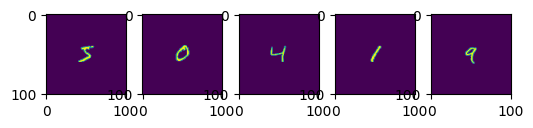

In [76]:
fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(expanded_mnist[i])

In [79]:
[np.mean([normalized_dot(normalized_filters[i][2], expanded_mnist[j]) for i in range(6, 84, 7)]) for j in range(5)]

[211.836028224664,
 225.82357371603845,
 170.6312215760204,
 169.38342925643397,
 194.81384782480066]

## T-sne with "Normalized dot"-processing

In [96]:
new_representations = np.array([np.array([normalized_dot(filter[2], mnist) for filter in normalized_filters]) for mnist in expanded_mnist])

In [98]:
tsne_new = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(new_representations)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


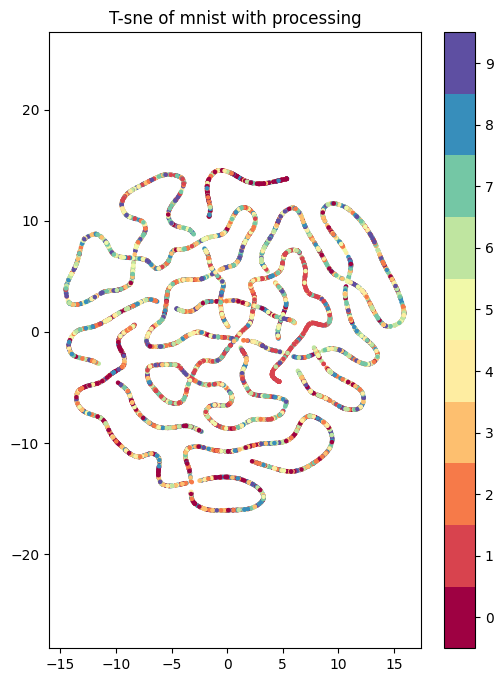

In [102]:
make_t_sne(tsne=tsne_new, y=labels, title='T-sne of mnist with normalized dot-processing')

## T-sne with angle-processing

In [104]:
angle_representations = np.array([np.array([np.mean(angle_between(filter[2], mnist)) for filter in normalized_filters]) for mnist in expanded_mnist])

In [107]:
tsne_angle_1 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(angle_representations)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


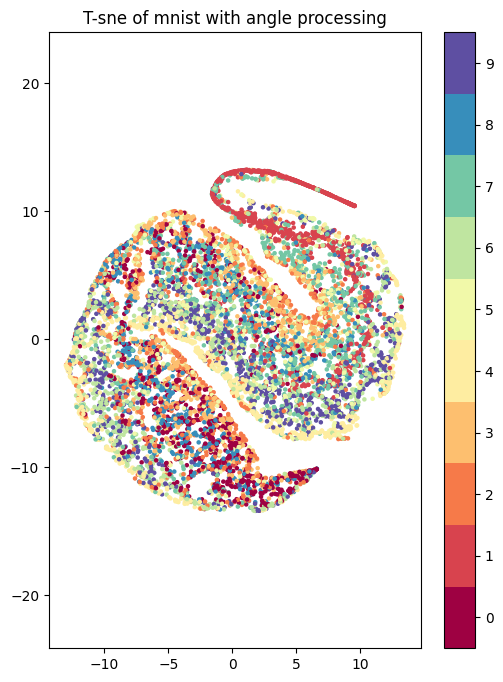

In [108]:
make_t_sne(tsne=tsne_angle_1, y=labels, title='T-sne of mnist with angle processing')

## T-sne with angle and max pooling processing

In [73]:
horizontal_filters_idx = (0, 1, 11)
diag_1_filters_idx = (2, 3, 4)
vertical_filters_idx = (5, 6, 7)
diag_2_filters_idx = (8, 9, 10)

horizontal_filters = [f[2] for f in normalized_filters if f[1] in  horizontal_filters_idx]
diag_1_filters = [f[2] for f in normalized_filters if f[1] in  diag_1_filters_idx]
vertical_filters = [f[2] for f in normalized_filters if f[1] in  vertical_filters_idx]
diag_2_filters = [f[2] for f in normalized_filters if f[1] in  diag_2_filters_idx]

In [194]:
max_pool_representations = []

for mn in expanded_mnist:
    h = np.max(np.array([angle_between_2(filt, mn) for filt in horizontal_filters]))
    d1 = np.max(np.array([angle_between_2(filt, mn) for filt in diag_1_filters]))
    v = np.max(np.array([angle_between_2(filt, mn) for filt in vertical_filters]))
    d2 = np.max(np.array([angle_between_2(filt, mn) for filt in diag_2_filters]))
    max_pool_representations.append((h, d1, v, d2))


In [197]:
tsne_angle_2 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(np.array(max_pool_representations))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


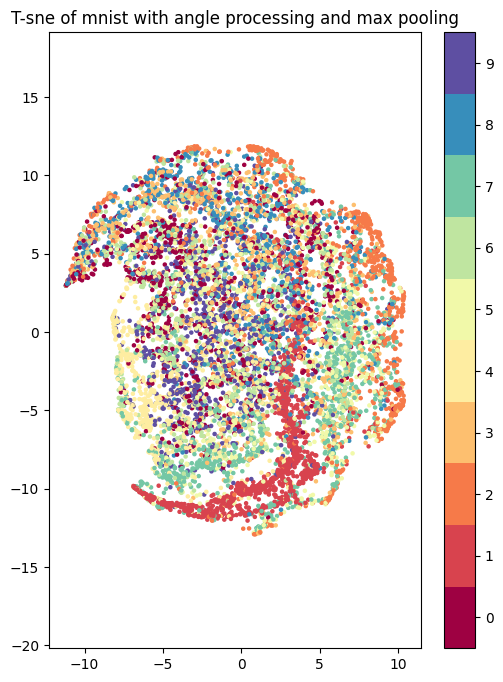

In [200]:
make_t_sne(tsne=tsne_angle_2, y=labels, title='T-sne of mnist with angle processing and max pooling')

## T-sne with normalized dot product

In [204]:
normalized_dot_2(normalized_filters[1][2], expanded_mnist[1])

0.3063231191864657

### Max pooled representations (each mnist representation is represented by a 4-element vector)

In [211]:
max_pool_dot_reps = []

for mn in expanded_mnist:
    h = np.max(np.array([normalized_dot_2(filt, mn) for filt in horizontal_filters]))
    d1 = np.max(np.array([normalized_dot_2(filt, mn) for filt in diag_1_filters]))
    v = np.max(np.array([normalized_dot_2(filt, mn) for filt in vertical_filters]))
    d2 = np.max(np.array([normalized_dot_2(filt, mn) for filt in diag_2_filters]))
    max_pool_dot_reps.append((h, d1, v, d2))

In [212]:
tsne_dot_2 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(np.array(max_pool_dot_reps))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


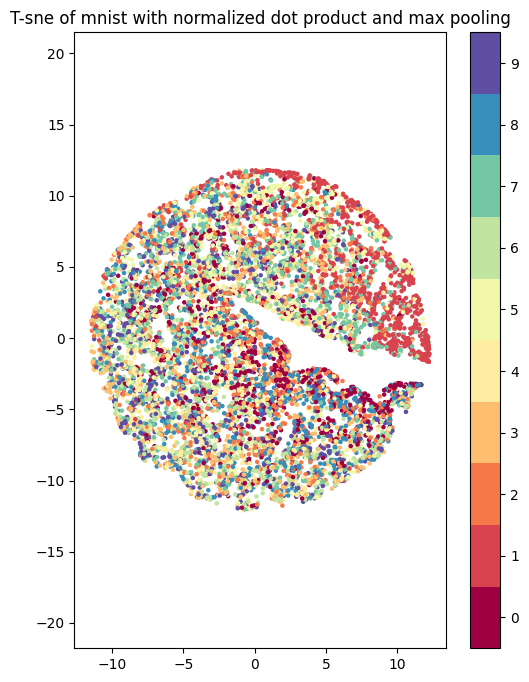

In [213]:
make_t_sne(tsne=tsne_dot_2, y=labels, title='T-sne of mnist with normalized dot product and max pooling')

### Without max pooling

In [214]:
dot_reps = np.array([np.array([normalized_dot_2(filter[2], mnist) for filter in normalized_filters]) for mnist in expanded_mnist])

In [215]:
tsne_dot_reps = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(np.array(dot_reps))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


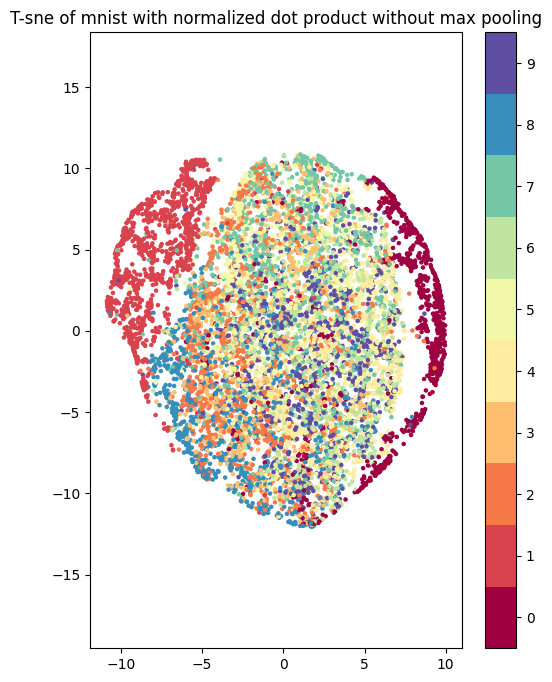

In [216]:
make_t_sne(tsne=tsne_dot_reps, y=labels, title='T-sne of mnist with normalized dot product without max pooling')

## Grid representations

###  grid

Grid senters:

- 50, 50
- 40, 40
- 40, 60
- 60, 40
- 60, 60

In [15]:
centers = [(50, 50), (40, 40), (40, 60), (60, 40), (60, 60)]

In [18]:
#only if filter and image are same size
def normalized_dot_center(image, filter_kernel, center_coordinates):

    filter_height, filter_width = filter_kernel.shape

    top_left_x = max(center_coordinates[0] - (filter_width // 2), 0)
    top_left_y = max(center_coordinates[1] - (filter_height // 2), 0)

    bottom_right_x = min(center_coordinates[0] + (filter_width // 2), filter_width)
    bottom_right_y = min(center_coordinates[1] + (filter_height // 2), filter_height)

    adjusted_filter = filter_kernel[top_left_x:bottom_right_x,
                    top_left_y:bottom_right_y]

    adjusted_image = image[top_left_x:bottom_right_x,
                    top_left_y:bottom_right_y]

    changed_img = normalized_dot_2(adjusted_filter, adjusted_image)

    """ result_image = image

    result_image[top_left_x:bottom_right_x, top_left_y:bottom_right_y] = changed_img
    """
    return changed_img

In [19]:
tight_grid_dot_reps = np.array([np.array([np.array([normalized_dot_center(mnist, filter[2], coordinates) for coordinates in centers]) for filter in normalized_filters]) for mnist in expanded_mnist])

In [22]:
tight_grid_dot_reps.shape

(10000, 84, 5)

In [24]:
tight_grid_reshaped = tight_grid_dot_reps.copy()
tight_grid_reshaped = tight_grid_reshaped.reshape((10000, 420))

In [25]:
tsne_dot_grid_reps = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(np.array(tight_grid_reshaped))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


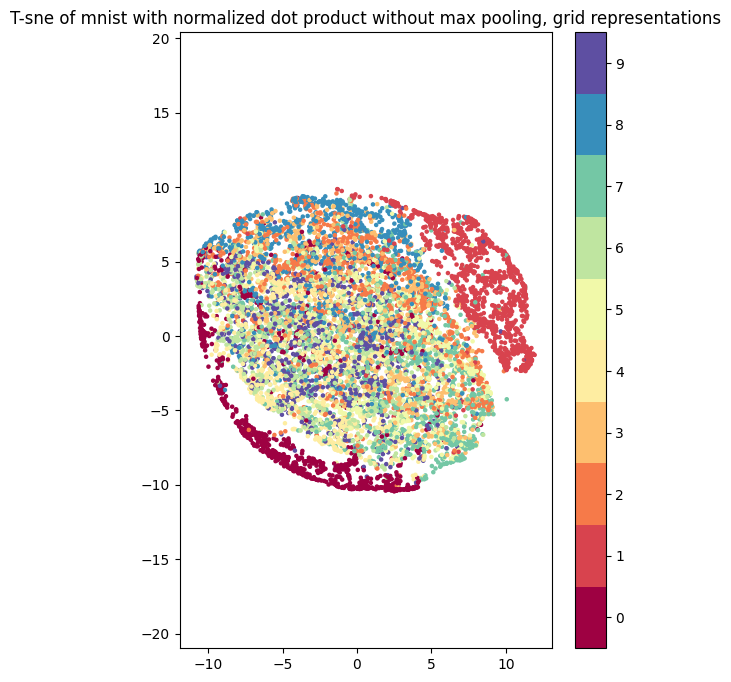

In [26]:
make_t_sne(tsne=tsne_dot_grid_reps, y=labels, title='T-sne of mnist with normalized dot product without max pooling, grid representations')

### Making more centers

### Tighter grid, 5x5

Grid senters:

- (40, 40), (40, 45), (40, 50), (40, 55), (40, 60)
- (45, 40), (45, 45), (45, 50), (45, 55), (45, 60)
- (50, 40), (50, 45), (50, 50), (50, 55), (50, 60)
- (55, 40), (55, 45), (55, 50), (55, 55), (55, 60)
- (60, 40), (60, 45), (60, 50), (60, 55), (60, 60)

In [28]:
centers_2 = [
    (40, 40), (40, 45), (40, 50), (40, 55), (40, 60),
    (45, 40), (45, 45), (45, 50), (45, 55), (45, 60),
    (50, 40), (50, 45), (50, 50), (50, 55), (50, 60),
    (55, 40), (55, 45), (55, 50), (55, 55), (55, 60),
    (60, 40), (60, 45), (60, 50), (60, 55), (60, 60)
]

In [29]:
tight_grid_dot_reps_2 = np.array([np.array([np.array([normalized_dot_center(mnist, filter[2], coordinates) for coordinates in centers_2]) for filter in normalized_filters]) for mnist in expanded_mnist])

In [70]:
tight_grid_dot_reps_2[0][0]

array([0.42282465, 0.42241256, 0.42209282, 0.42234415, 0.4227298 ,
       0.42280631, 0.42239212, 0.42207018, 0.42232327, 0.42271106,
       0.42279356, 0.42237775, 0.42205408, 0.42230856, 0.422698  ,
       0.42280351, 0.42238897, 0.42206666, 0.42232005, 0.42270818,
       0.42282018, 0.42240761, 0.42208737, 0.42233909, 0.42272523])

In [30]:
tight_grid_reshaped_2 = tight_grid_dot_reps_2.copy()
tight_grid_reshaped_2 = tight_grid_reshaped_2.reshape((10000, 2100))

In [31]:
tsne_dot_grid_reps_2 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(np.array(tight_grid_reshaped_2))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


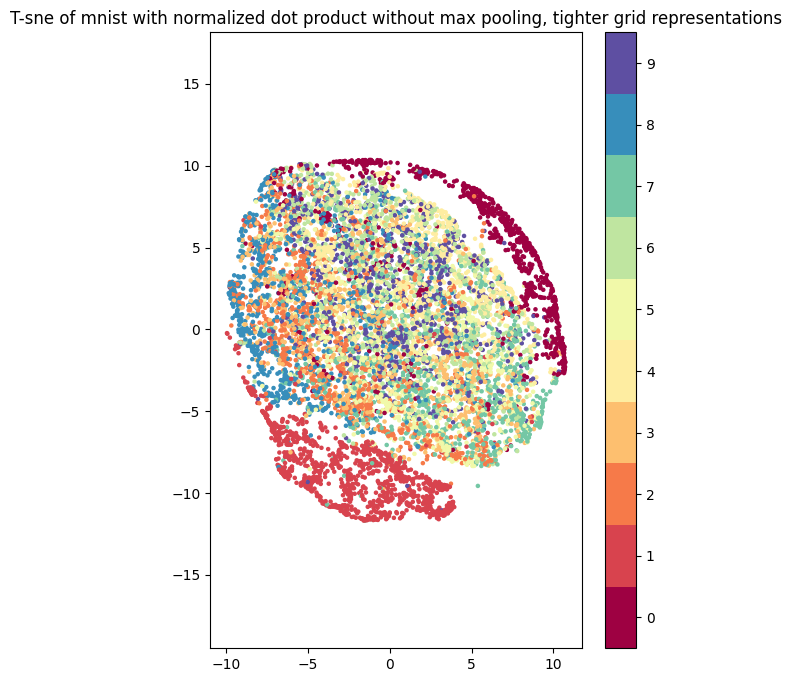

In [32]:
make_t_sne(tsne=tsne_dot_grid_reps_2, y=labels, title='T-sne of mnist with normalized dot product without max pooling, tighter grid representations')

### Octagonal grid

Octagonal placement around 50, 50

In [33]:
centers_3 = [
    (50, 50), (46, 60), (40, 54), (40, 46), (46, 40), (54, 40), (60, 46), (60, 54), (54, 60)
]

In [34]:
tight_grid_dot_reps_3 = np.array([np.array([np.array([normalized_dot_center(mnist, filter[2], coordinates) for coordinates in centers_3]) for filter in normalized_filters]) for mnist in expanded_mnist])

In [35]:
tight_grid_reshaped_3 = tight_grid_dot_reps_3.copy()
tight_grid_reshaped_3 = tight_grid_reshaped_3.reshape((10000, 756))

In [42]:
tsne_dot_grid_reps_3 = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=5000, learning_rate="auto").fit_transform(np.array(tight_grid_reshaped_3))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


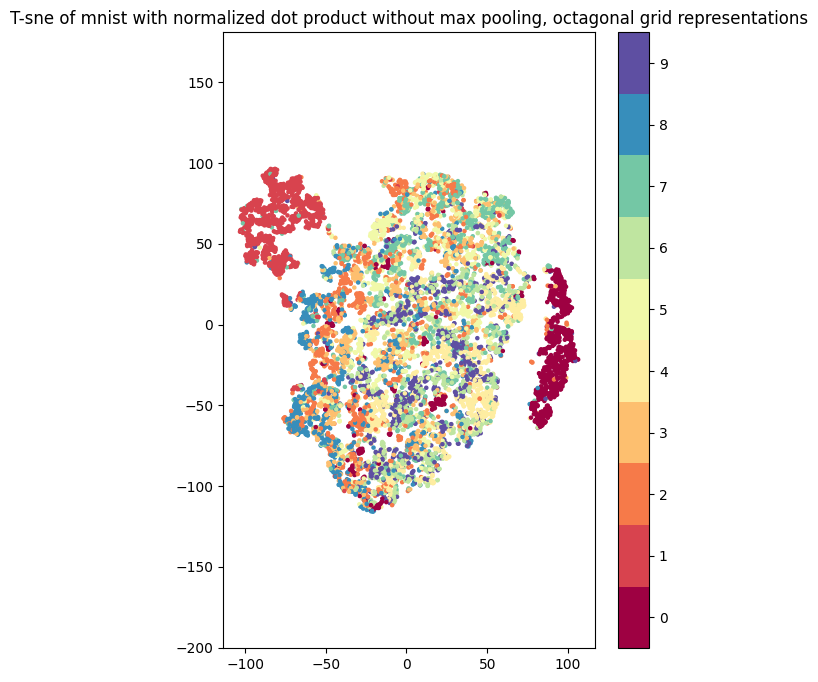

In [43]:
make_t_sne(tsne=tsne_dot_grid_reps_3, y=labels, title='T-sne of mnist with normalized dot product without max pooling, octagonal grid representations')

### Introducing some noise

In [273]:
mnist_copy = expanded_mnist.copy()
noisy_mnist = [img + np.random.normal(.0, 0.5, size=(expanded_mnist[0].shape)) for img in mnist_copy]

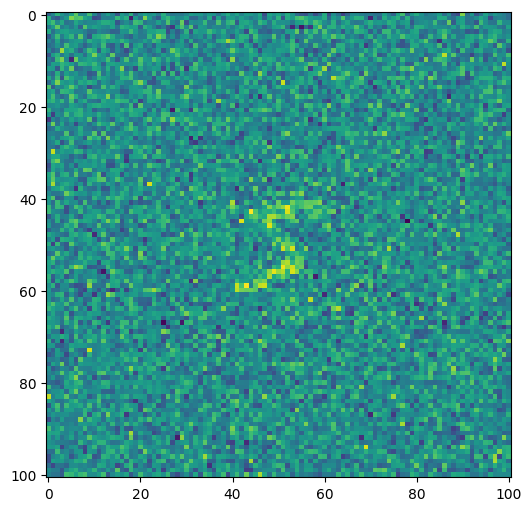

In [274]:
plt.imshow(noisy_mnist[0])

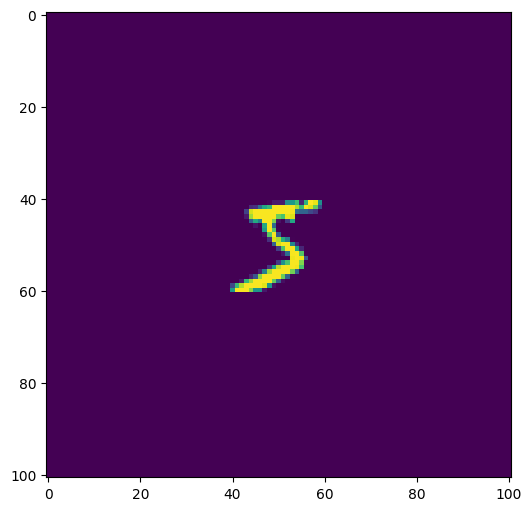

In [50]:
plt.imshow(expanded_mnist[0])

In [53]:
reshaped_mnist_expanded = expanded_mnist.reshape(10000, 101*101)

In [54]:
tsne_expanded = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(reshaped_mnist_expanded)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


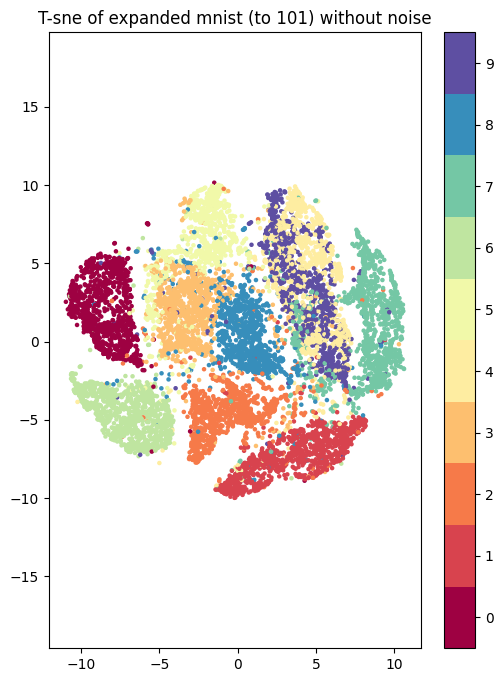

In [56]:
make_t_sne(tsne=tsne_expanded, y=labels, title='T-sne of expanded mnist (to 101) without noise')

In [58]:
reshaped_noisy_mnist = np.array(noisy_mnist).reshape(10000, 101*101)

In [60]:
tsne_noisy_mnist = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(reshaped_noisy_mnist)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


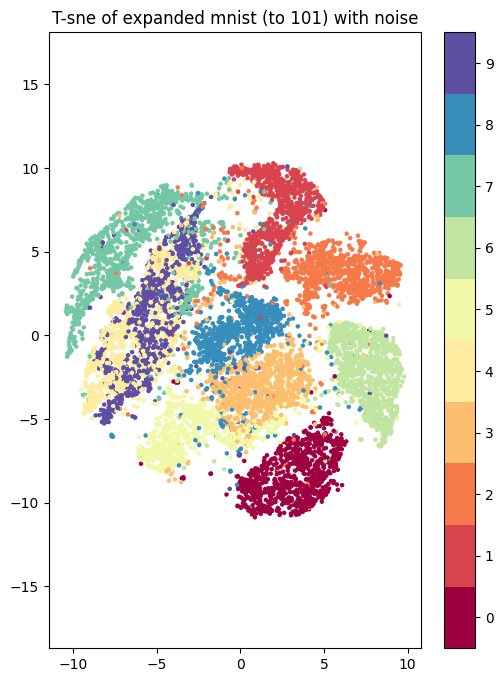

In [68]:
make_t_sne(tsne=tsne_noisy_mnist, y=labels, title='T-sne of expanded mnist (to 101) with noise')

### Small grid with noise

In [62]:
tight_grid_noisy_reps = np.array([np.array([np.array([normalized_dot_center(mnist, filter[2], coordinates) for coordinates in centers]) for filter in normalized_filters]) for mnist in noisy_mnist])

In [63]:
tight_grid_noisy_reshaped = tight_grid_noisy_reps.copy()
tight_grid_noisy_reshaped = tight_grid_noisy_reshaped.reshape((10000, 420))

In [66]:
tsne_noisy_grid_reps = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(np.array(tight_grid_noisy_reshaped))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


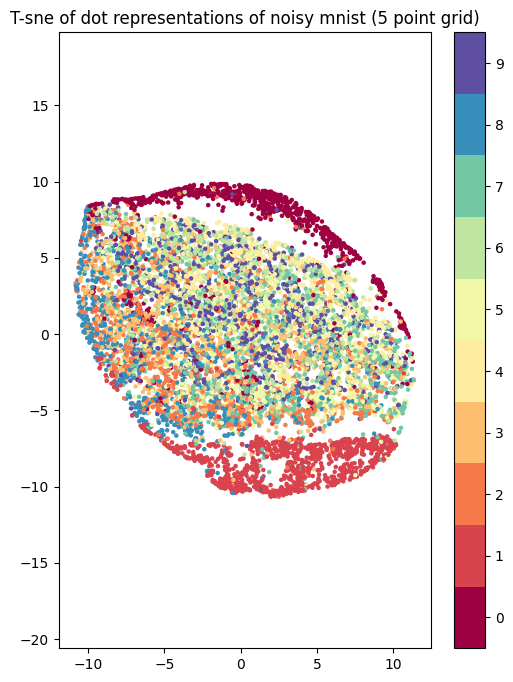

In [67]:
make_t_sne(tsne=tsne_noisy_grid_reps, y=labels, title='T-sne of dot representations of noisy mnist (5 point grid)')

### Max pooling with 5x5 grid

In [161]:
max_pool_dot_grid_reps = []

In [79]:
for mn in expanded_mnist:
    h = ([np.max(np.array([normalized_dot_center(filt, mn, coordinates) for filt in horizontal_filters])) for coordinates in centers_2])
    d1 = ([np.max(np.array([normalized_dot_center(filt, mn, coordinates) for filt in diag_1_filters])) for coordinates in centers_2])
    v = ([np.max(np.array([normalized_dot_center(filt, mn, coordinates) for filt in vertical_filters])) for coordinates in centers_2])
    d2 = ([np.max(np.array([normalized_dot_center(filt, mn, coordinates) for filt in diag_2_filters])) for coordinates in centers_2])
    max_pool_dot_grid_reps.append(np.array([h, d1, v, d2]))

- Fikse max pooling
- Gange med absoluttverdi av filteret, normalisere den vektmatrisa, også gange med 

In [82]:
max_pool_dot_grid_reps[0].shape

(4, 25)

In [84]:
max_pool_dot_grid_reps_reshaped = np.array(max_pool_dot_grid_reps).copy()
max_pool_dot_grid_reps_reshaped = max_pool_dot_grid_reps_reshaped.reshape((10000, 100))

In [89]:
tsne_max_pool_grid = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, learning_rate="auto").fit_transform(max_pool_dot_grid_reps_reshaped)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


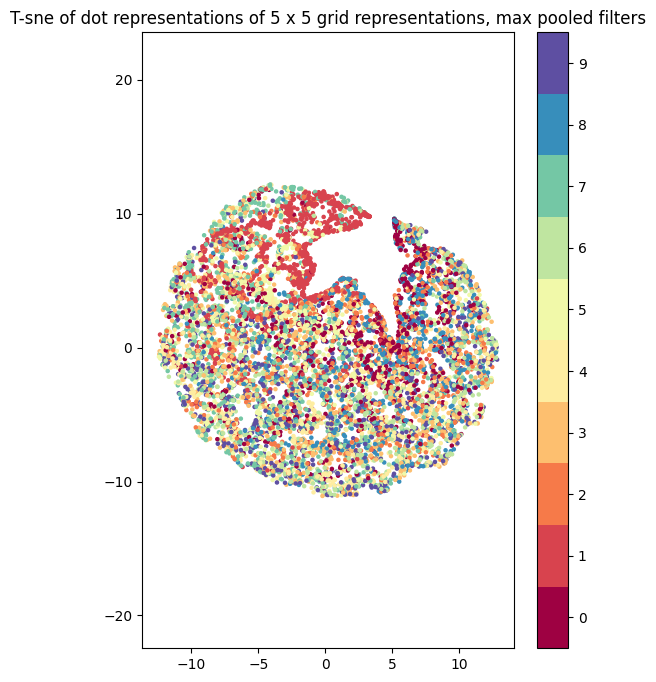

In [90]:
make_t_sne(tsne=tsne_max_pool_grid, y=labels, title='T-sne of dot representations of 5 x 5 grid representations, max pooled filters')

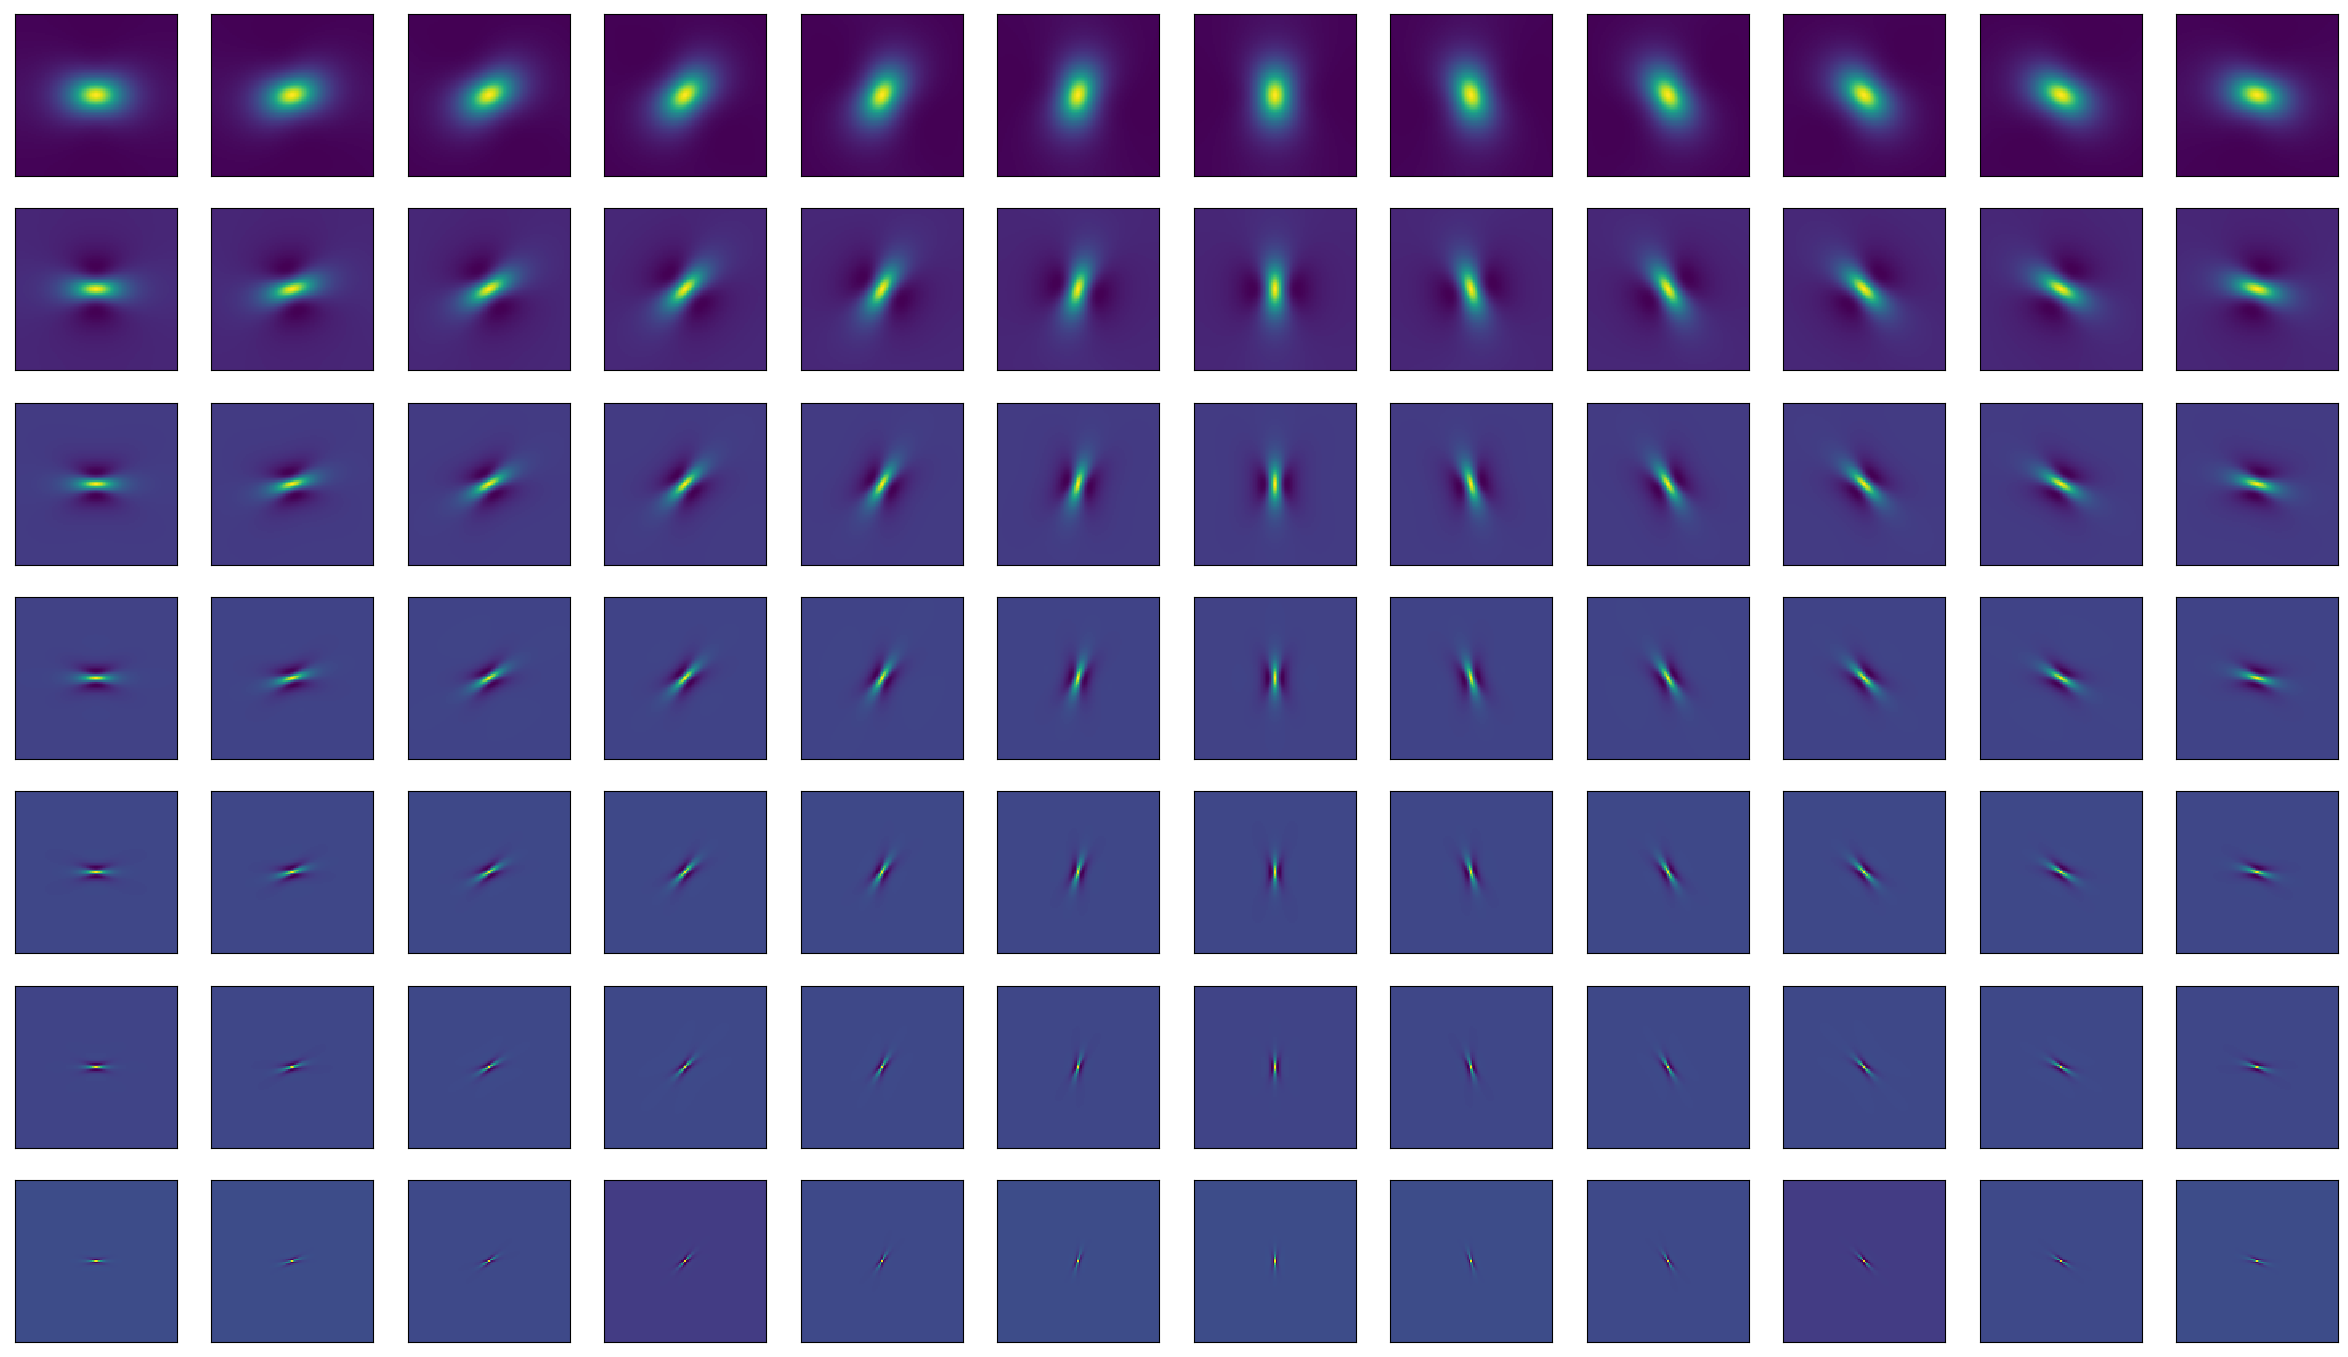

In [99]:
fig, axes = plt.subplots(7, 12)

for img_arr in filterbank:
    axes[img_arr[0], img_arr[1]].matshow(img_arr[2])
    axes[img_arr[0], img_arr[1]].axes.get_xaxis().set_ticks([])
    axes[img_arr[0], img_arr[1]].axes.get_yaxis().set_ticks([])

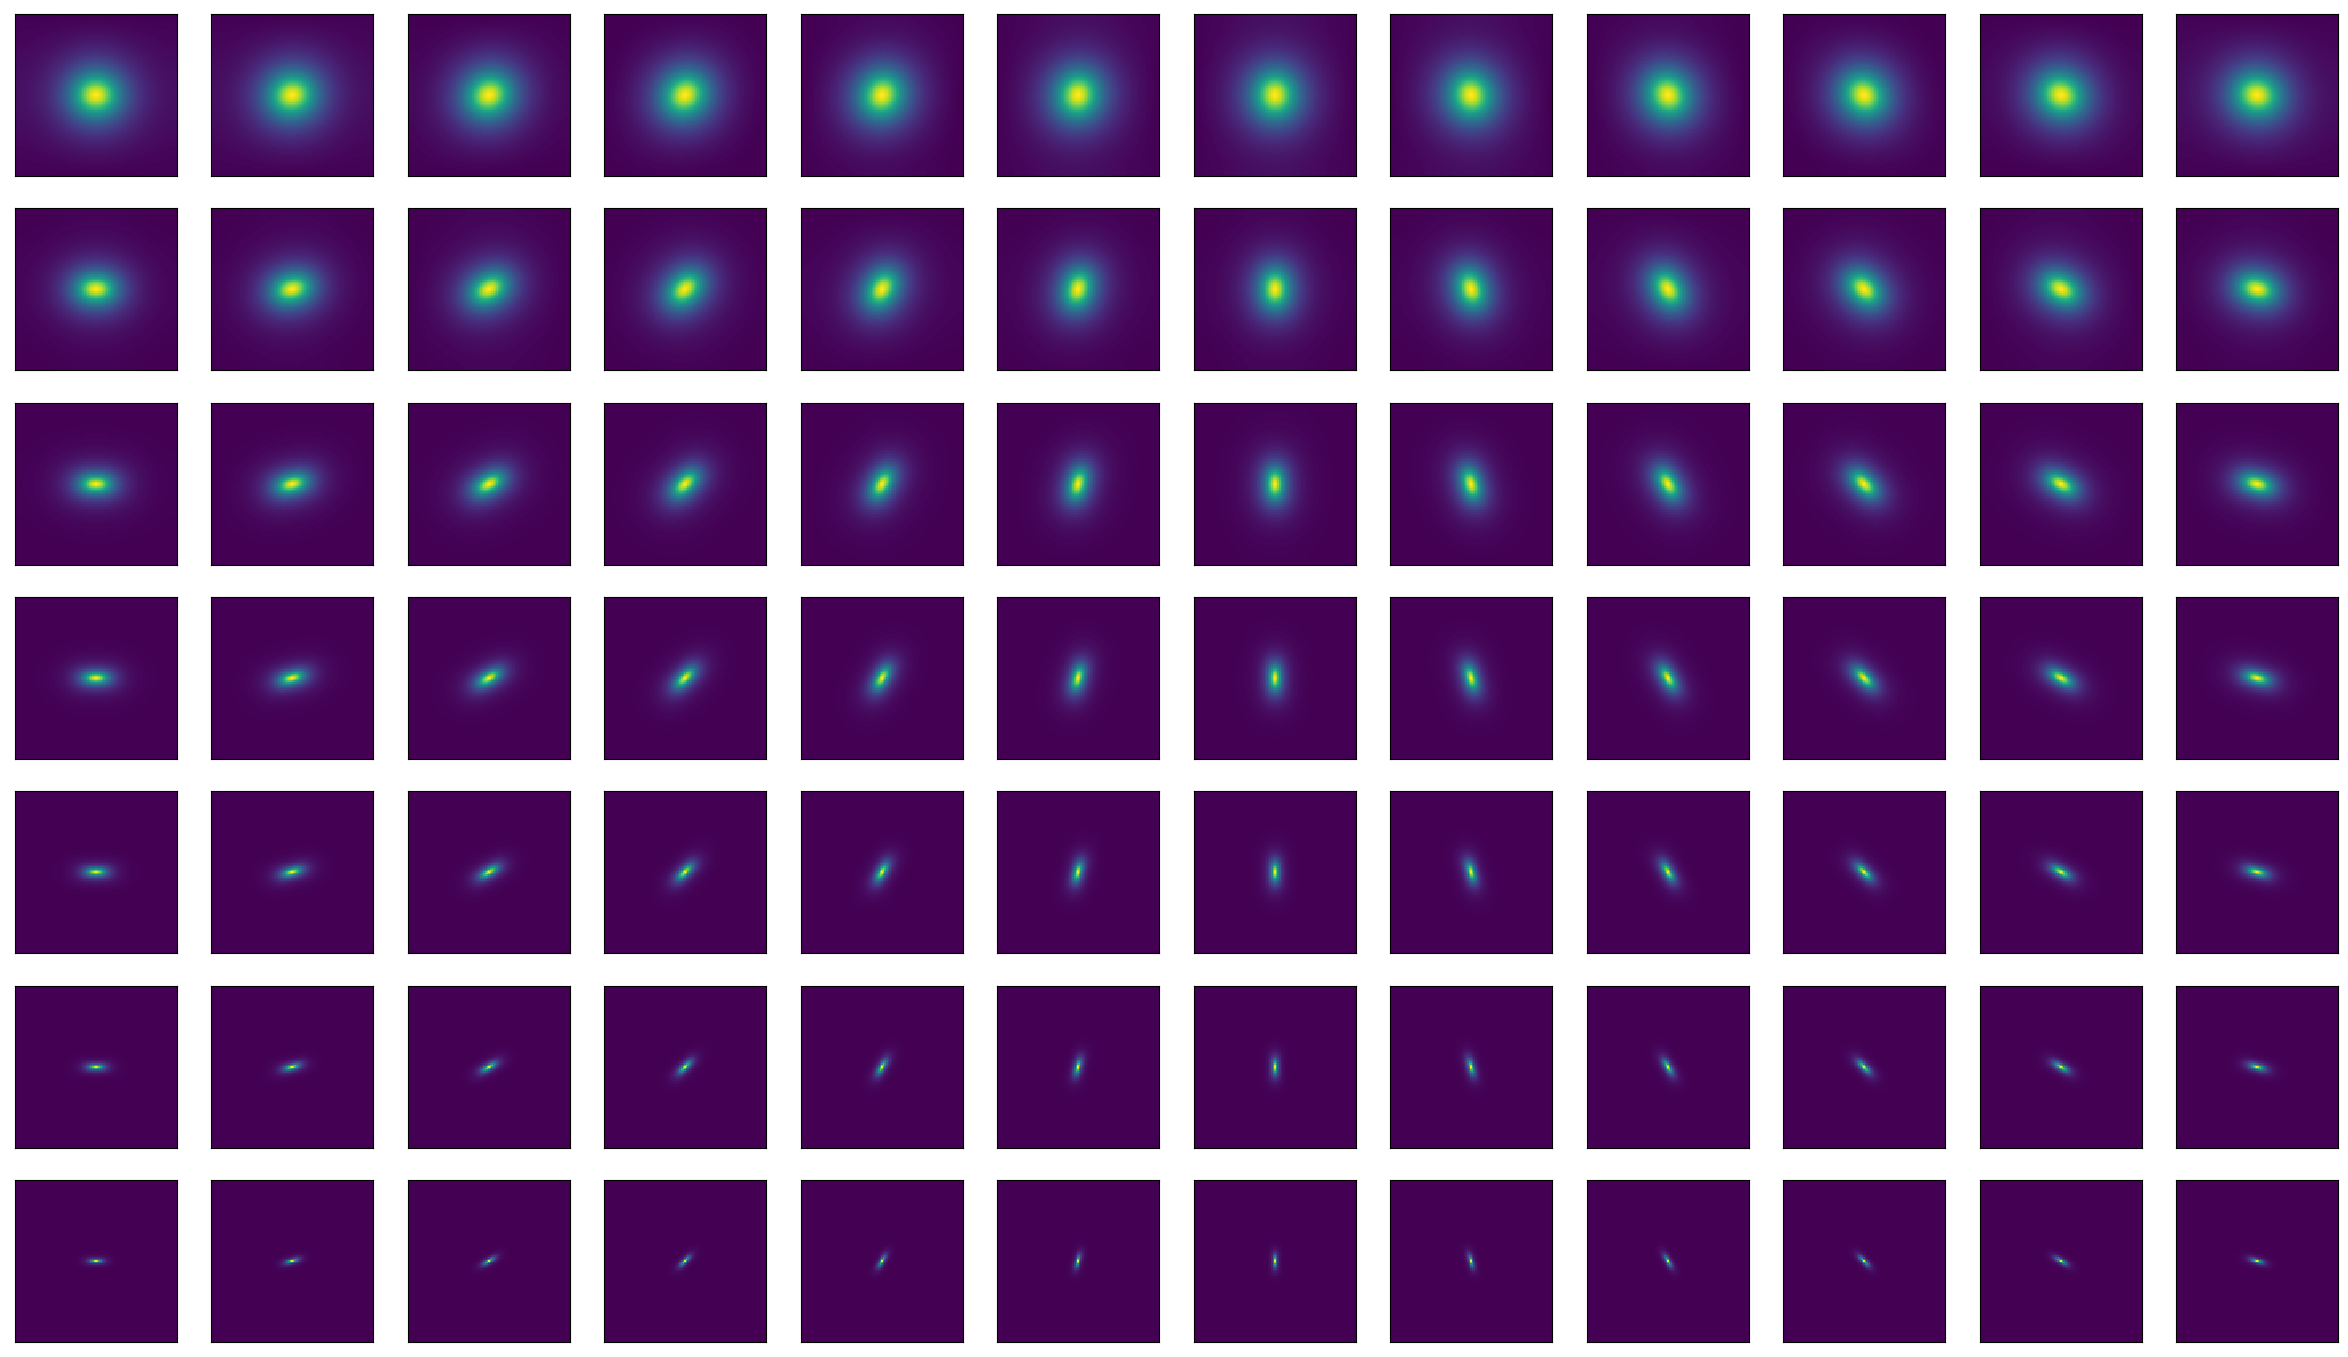

In [100]:
fig, axes = plt.subplots(7, 12)

for img_arr in abs_filterbank:
    axes[img_arr[0], img_arr[1]].matshow(img_arr[2])
    axes[img_arr[0], img_arr[1]].axes.get_xaxis().set_ticks([])
    axes[img_arr[0], img_arr[1]].axes.get_yaxis().set_ticks([])

In [143]:
weight_matrices = []

In [144]:
for i in range(len(filterbank)):
    weight_matrix = (filterbank[i][2] * abs_filterbank[i][2])
    w = weight_matrix.copy()
    weight_matrix = w/np.sqrt(np.sum(np.square(w)))
    weight_matrices.append((filterbank[i][0], filterbank[i][1], weight_matrix))

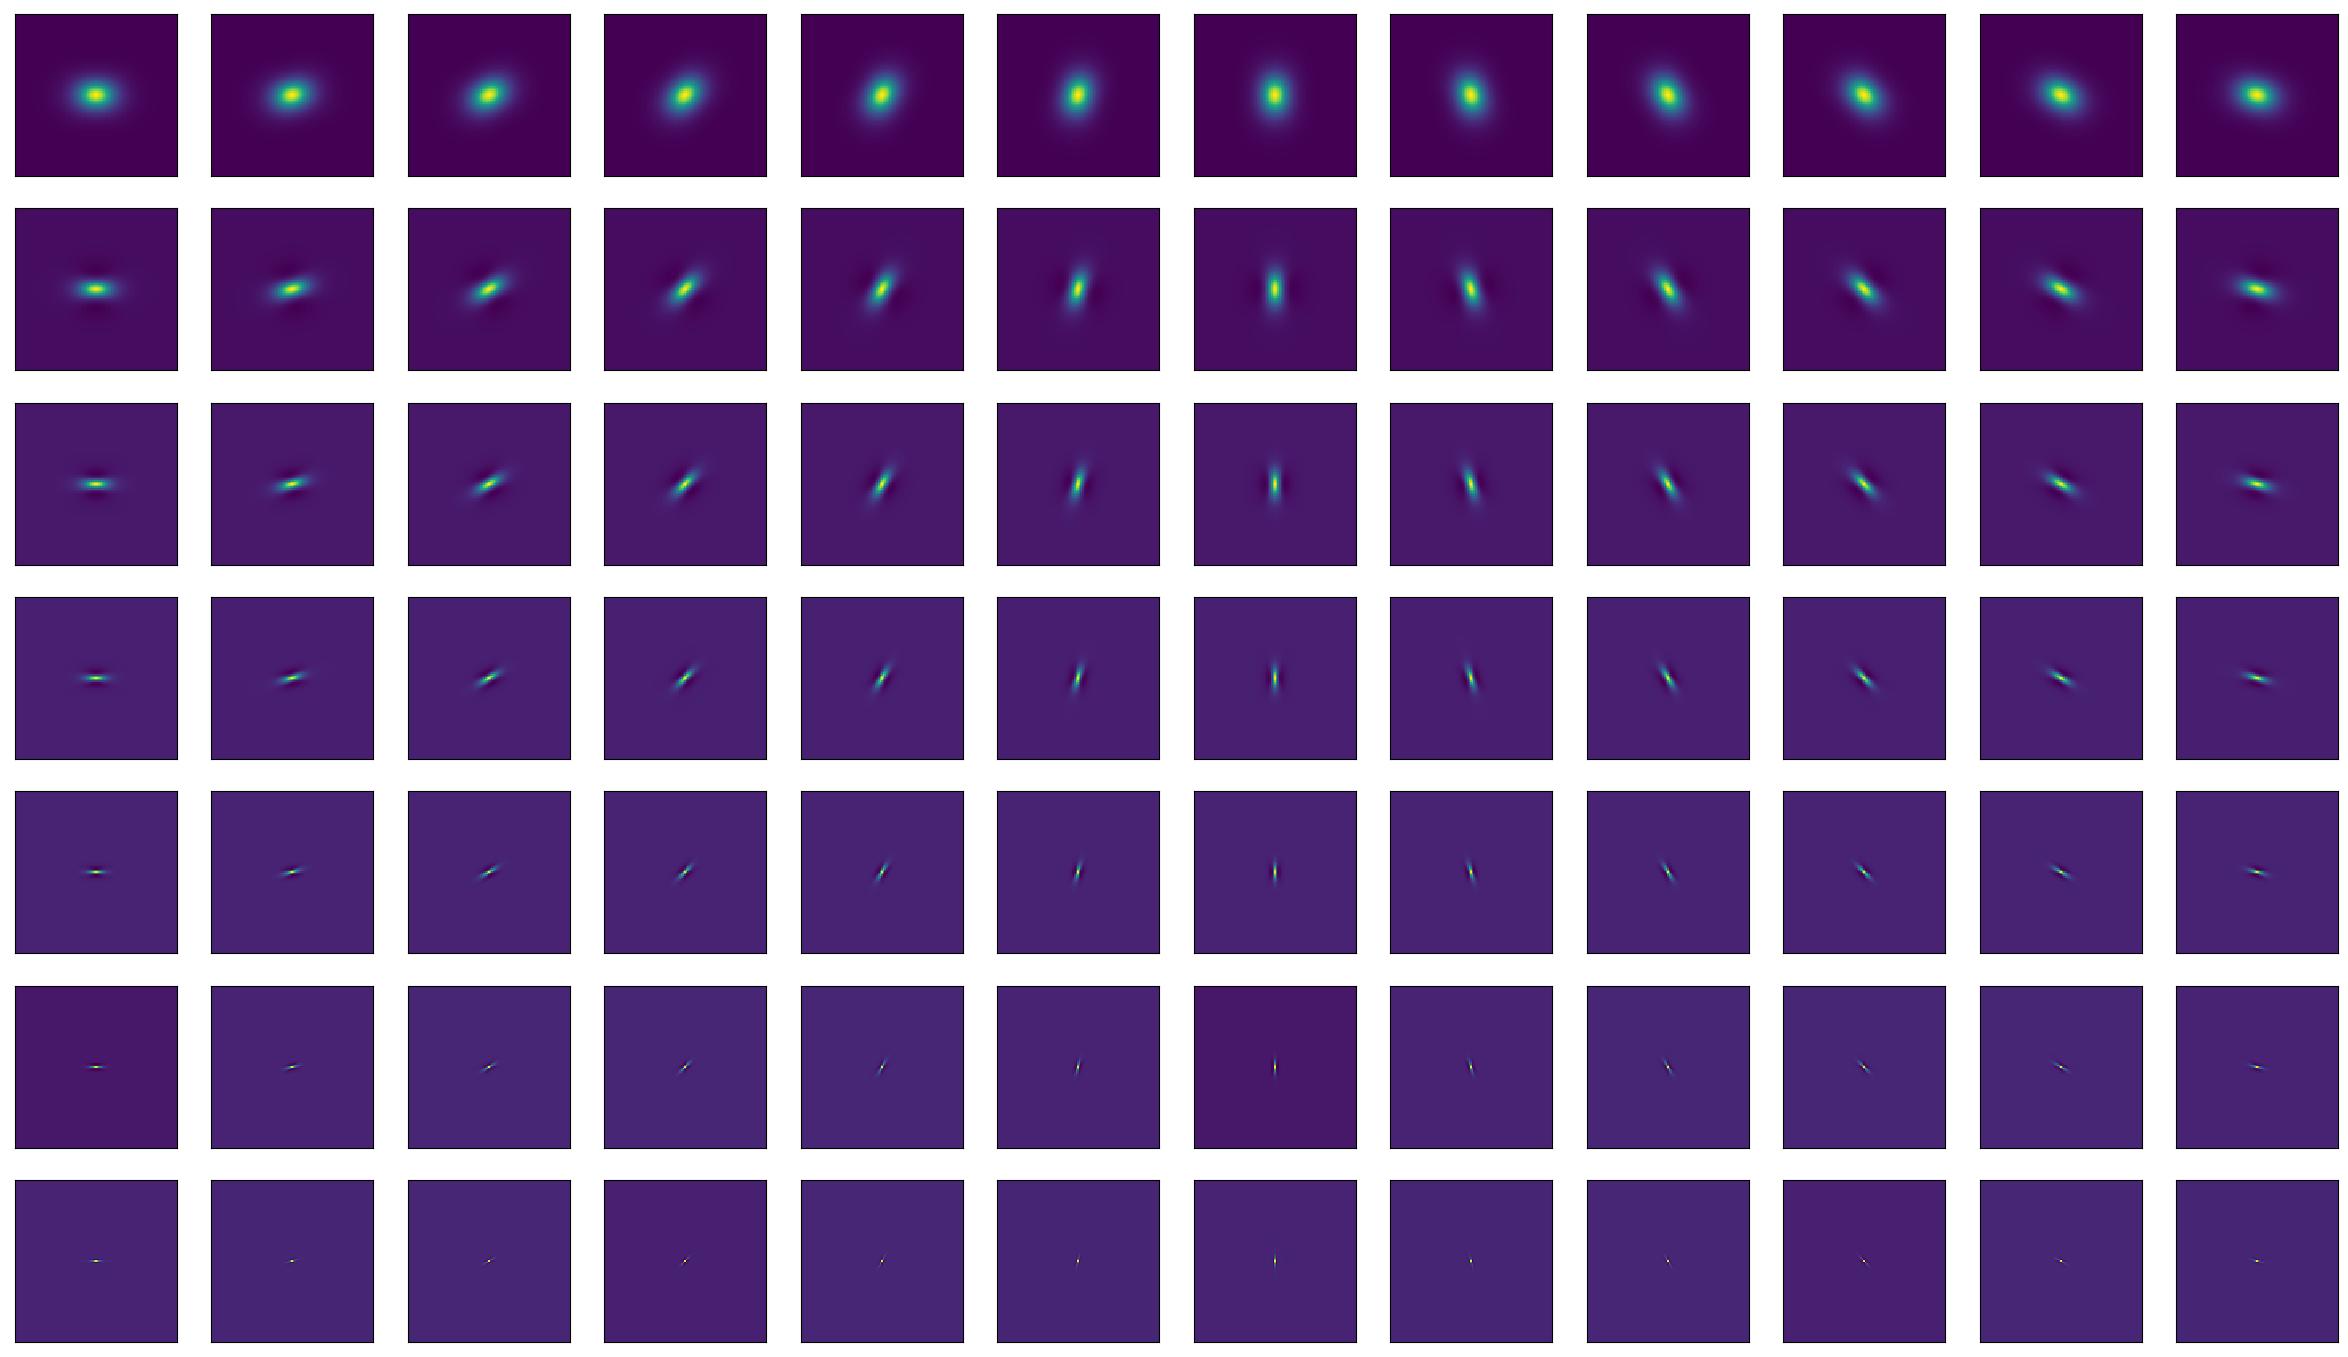

In [125]:
fig, axes = plt.subplots(7, 12)

for img_arr in weight_matrices:
    axes[img_arr[0], img_arr[1]].matshow(img_arr[2])
    axes[img_arr[0], img_arr[1]].axes.get_xaxis().set_ticks([])
    axes[img_arr[0], img_arr[1]].axes.get_yaxis().set_ticks([])

In [134]:
for i in range (20):
    print(np.max(weight_matrices[i][2]), np.min(weight_matrices[i][2]))

0.08820769809837517 -2.3974675390901984e-06
0.1296738057382422 -0.0045621589522511115
0.19109935066274106 -0.013862316043358587
0.2829877997061973 -0.02679109292553289
0.4146303126807169 -0.04382198373629274
0.5355038921754606 -0.03749321692589987
0.6245754652124226 -0.07057233932927359
0.08822416888951813 5.8547236143763213e-08
0.12971076389378744 -0.004534401080204487
0.19111681297320232 -0.014087718610271076
0.2830752257518989 -0.026533829467882186
0.4207366218470496 -0.046221545239548766
0.608613240802563 -0.06613647340583327
0.8074366935309534 -0.09411436892528958
0.08825619921695424 4.215175571774289e-06
0.12977217534836435 -0.004580821608895231
0.19113541574122003 -0.013960807711777013
0.283106009063489 -0.027322094993039375
0.4222313036033296 -0.04683623192301442
0.6283165952375288 -0.07436873826824121


In [139]:
def weighted_normalized_dot(img, filt, weight):
    weighted_img = np.multiply(img, weight)
    return np.sum(weighted_img * filt)/(np.sqrt(np.sum(np.square(weighted_img))) * np.sqrt(np.sum(np.square(filt))))

In [138]:
normalized_dot_2(expanded_mnist[0], filterbank[2][2])

0.016554853688309425

In [140]:
weighted_normalized_dot(expanded_mnist[0], filterbank[2][2], weight_matrices[2][2])

0.4723014287652531

In [ ]:
mnist_temp = expanded_mnist.copy()
weighted_expanded_mnist = np.array([np.multiply(mnist_temp[nm][2], weight_matrices[nm][2]) for nm in range(len(expanded_mnist))])

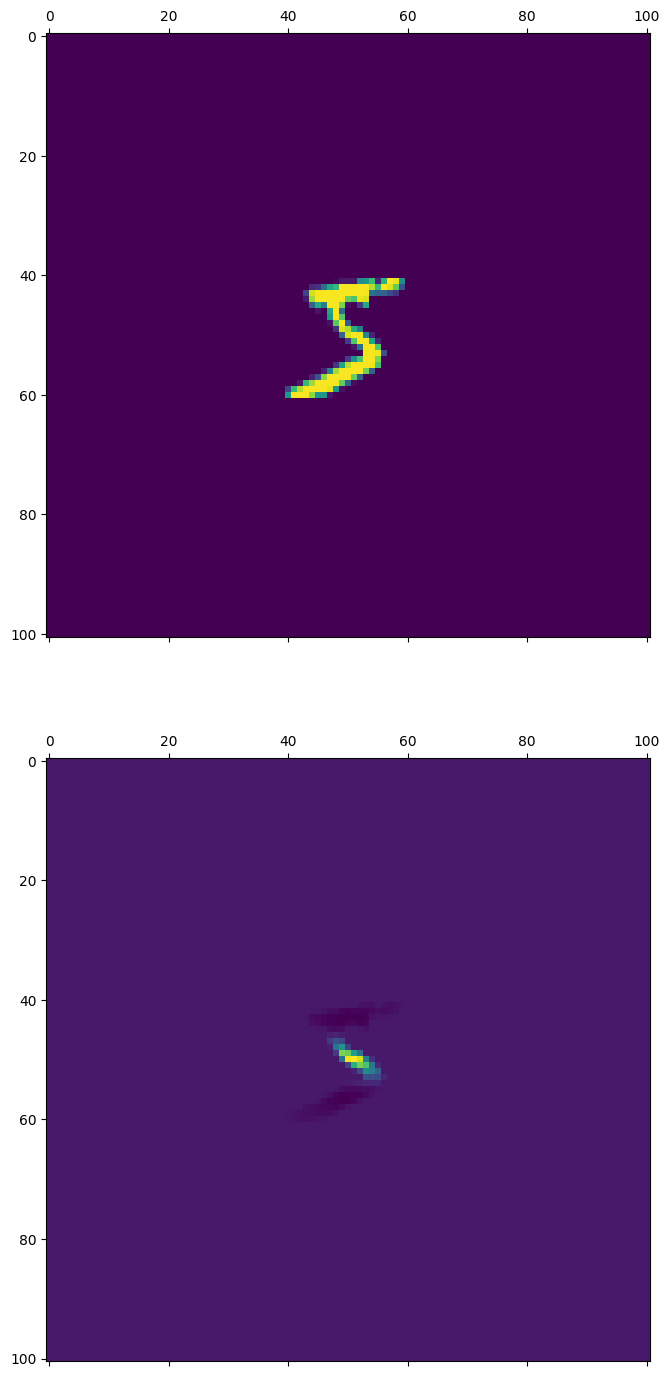

In [157]:
test_img = expanded_mnist[0].copy()
weight_test = weight_matrices[2][2].copy()

fig, axes = plt.subplots(2)
axes[0].matshow(test_img)
axes[1].matshow(np.multiply(test_img, weight_test))

In [212]:
def normalized_dot_center_weighted(image, filter_kernel, center_coordinates, weight_img):

    ## adjust image with weight matrix

    filter_height, filter_width = filter_kernel.shape

    top_left_x = max(center_coordinates[0] - (filter_width // 2), 0)
    top_left_y = max(center_coordinates[1] - (filter_height // 2), 0)

    bottom_right_x = min(center_coordinates[0] + (filter_width // 2), filter_width)
    bottom_right_y = min(center_coordinates[1] + (filter_height // 2), filter_height)

    adjusted_weight = weight_img[top_left_x:bottom_right_x,
                    top_left_y:bottom_right_y]

    adjusted_image = image[top_left_x:bottom_right_x,
                    top_left_y:bottom_right_y]

    adjusted_filter = filter_kernel[top_left_x:bottom_right_x,
                    top_left_y:bottom_right_y]

    weighted_img = np.multiply(adjusted_weight, adjusted_image)

    return np.sum(weighted_img * adjusted_filter)/(np.sqrt(np.sum(np.square(weighted_img))) * np.sqrt(np.sum(np.square(adjusted_filter))))    

### Test again with 5x5 grid

In [254]:
max_pool_weight_dot_grid_reps = []

In [255]:
horizontal_filters_list_idx = [i for i in range(84) if np.floor(i/7) in horizontal_filters_idx]
diag_1_filters_list_idx = [i for i in range(84) if np.floor(i/7) in  diag_1_filters_idx]
vertical_filters_list_idx = [i for i in range(84) if np.floor(i/7) in  vertical_filters_idx]
diag_2_filters_list_idx = [i for i in range(84) if np.floor(i/7) in  diag_2_filters_idx]

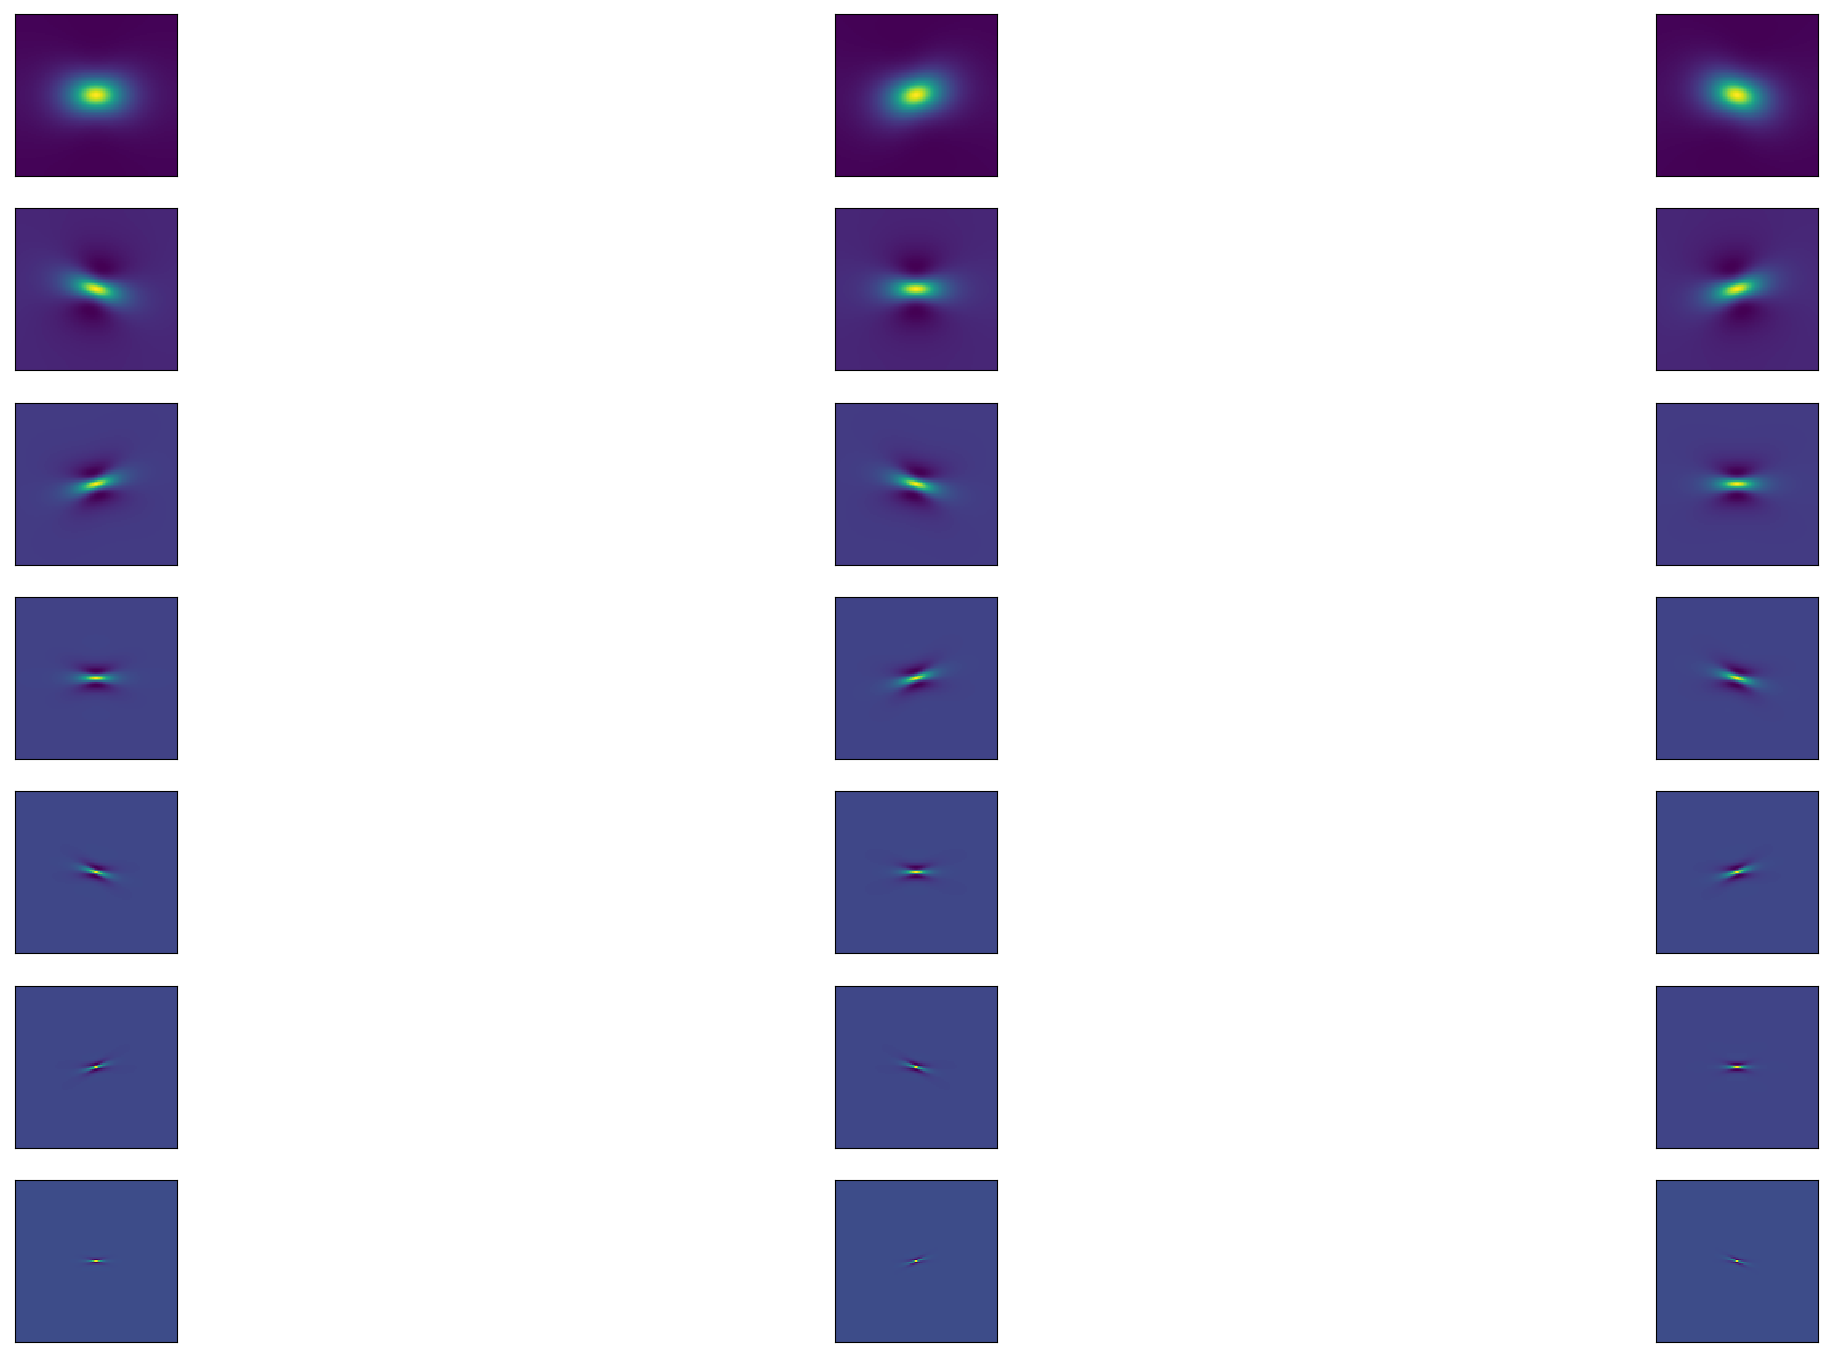

In [198]:
fig, axes = plt.subplots(7, 3)

for idx in horizontal_filters_list_idx:
    axes[idx % 7, idx % 3].matshow(normalized_filters[idx][2])
    axes[idx % 7, idx % 3].axes.get_xaxis().set_ticks([])
    axes[idx % 7, idx % 3].axes.get_yaxis().set_ticks([])

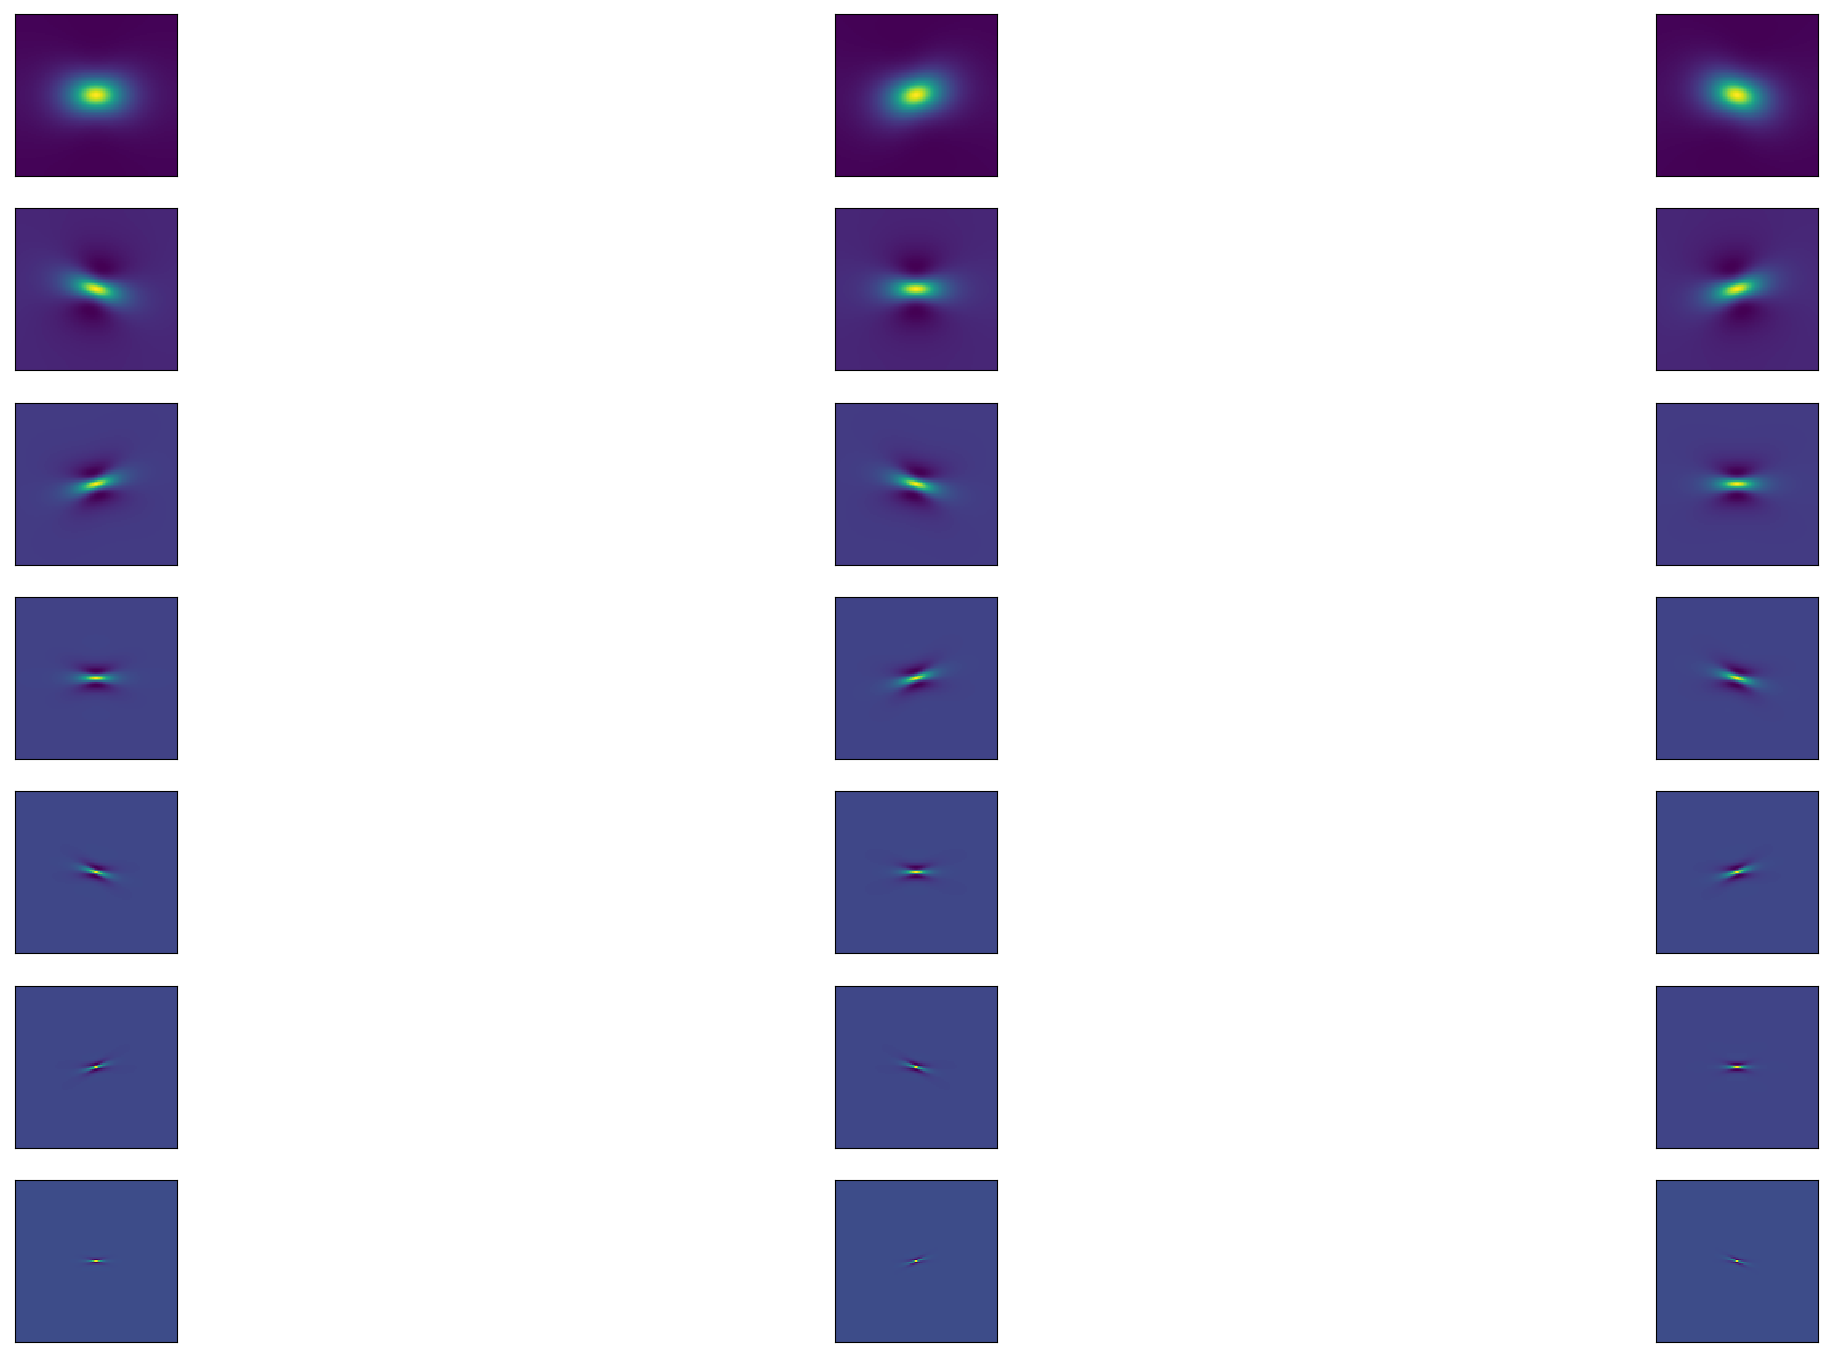

In [171]:
fig, axes = plt.subplots(7, 3)
temp = 0
for filt in horizontal_filters:
    axes[temp % 7, temp % 3].matshow(filt)
    axes[temp % 7, temp % 3].axes.get_xaxis().set_ticks([])
    axes[temp % 7, temp % 3].axes.get_yaxis().set_ticks([])
    temp += 1

In [256]:
horizontal_filters_and_weights = [(normalized_filters[i][2], weight_matrices[i][2]) for i in horizontal_filters_list_idx]
diag_1_filters_and_weights = [(normalized_filters[i][2], weight_matrices[i][2]) for i in diag_1_filters_list_idx]
vertical_filters_and_weights = [(normalized_filters[i][2], weight_matrices[i][2]) for i in vertical_filters_list_idx]
diag_2_filters_and_weights = [(normalized_filters[i][2], weight_matrices[i][2]) for i in diag_2_filters_list_idx]

In [257]:
""" image, filter_kernel, center_coordinates, weight_img """

for mn in expanded_mnist:
    h = ([np.max(np.array([normalized_dot_center_weighted(mn, filt[0], coordinates, filt[1]) for filt in horizontal_filters_and_weights])) for coordinates in centers_2])
    d1 = ([np.max(np.array([normalized_dot_center_weighted(mn, filt[0], coordinates, filt[1]) for filt in diag_1_filters_and_weights])) for coordinates in centers_2])
    v = ([np.max(np.array([normalized_dot_center_weighted(mn, filt[0], coordinates, filt[1]) for filt in vertical_filters_and_weights])) for coordinates in centers_2])
    d2 = ([np.max(np.array([normalized_dot_center_weighted(mn, filt[0], coordinates, filt[1]) for filt in diag_2_filters_and_weights])) for coordinates in centers_2])
    max_pool_weight_dot_grid_reps.append(np.array([h, d1, v, d2]))

In [258]:
max_pool_weight_dot_grid_reps_reshaped = np.array(max_pool_weight_dot_grid_reps).copy()
max_pool_weight_dot_grid_reps_reshaped = max_pool_weight_dot_grid_reps_reshaped.reshape((10000, 100))

In [271]:
tsne_max_pool_grid_weighted = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000, learning_rate="auto").fit_transform(max_pool_weight_dot_grid_reps_reshaped)

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


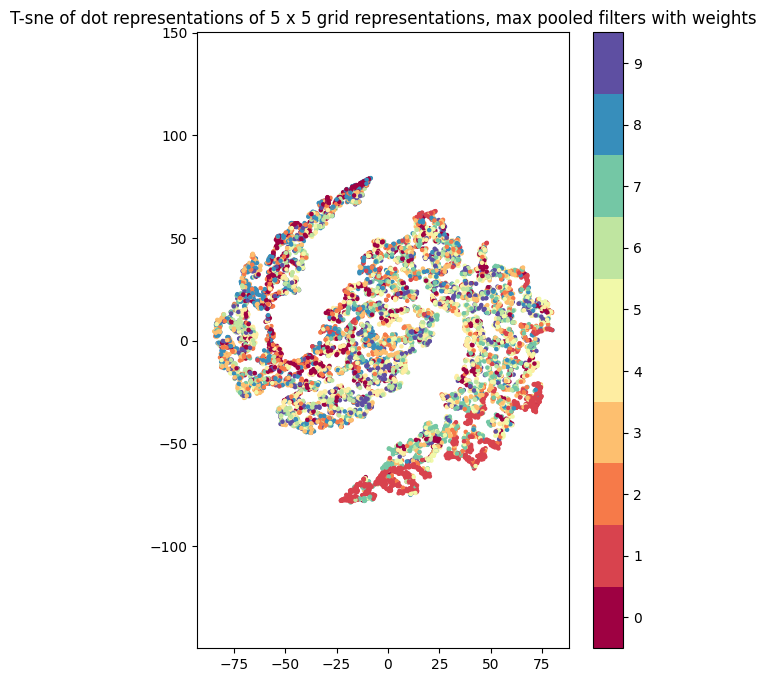

In [272]:
make_t_sne(tsne=tsne_max_pool_grid_weighted, y=labels, title='T-sne of dot representations of 5 x 5 grid representations, max pooled filters with weights')

## With thresholding

In [232]:
import seaborn as sns

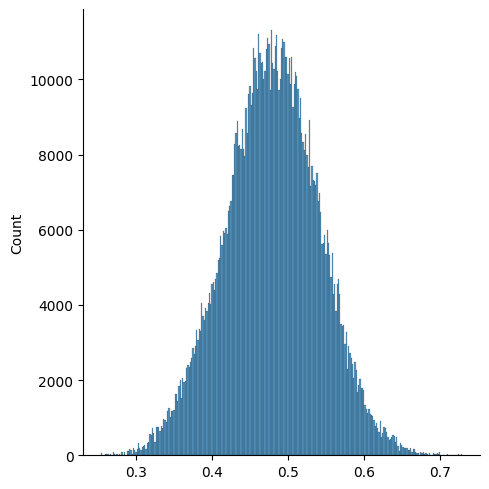

In [239]:
flattened = max_pool_weight_dot_grid_reps_reshaped.flatten()
sns.displot(flattened)

In [265]:
thresh_val = 0.55
threshholded = max_pool_weight_dot_grid_reps_reshaped.copy()
threshholded[threshholded < thresh_val] = .0
threshholded[threshholded >= thresh_val] = 1.0

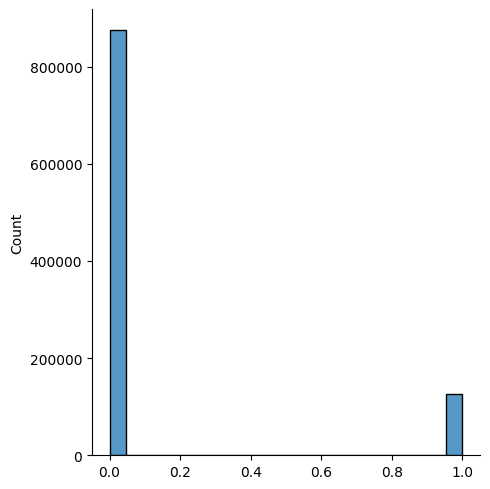

In [266]:
sns.displot(threshholded.flatten())

In [277]:
tsne_max_pool_grid_weighted_thresh = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000, learning_rate="auto").fit_transform(np.array(max_pool_weight_dot_grid_reps))

/opt/homebrew/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


ValueError: Found array with dim 3. TSNE expected <= 2.

(10000, 100)

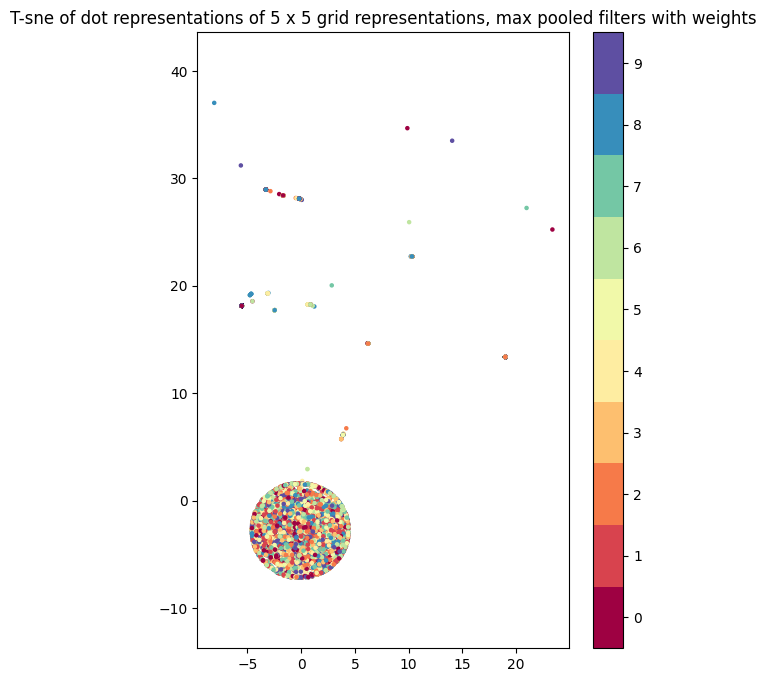

In [270]:
make_t_sne(tsne=tsne_max_pool_grid_weighted_thresh, y=labels, title='T-sne of dot representations of 5 x 5 grid representations, max pooled filters with weights')